In [1]:
import os
import sys
import math
import random
import joblib
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
sale = pd.read_excel(os.path.join('..', '..', '0.Data', '01_제공데이터', '2020 빅콘테스트 데이터분석분야-챔피언리그_2019년 실적데이터_v1_200818.xlsx'), skiprows = 1)

In [3]:
sale.head()

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0
1,2019-01-01 06:00:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0
3,2019-01-01 06:20:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0


In [4]:
meta_train = pd.read_excel(os.path.join('..', '..', '0.Data', '01_제공데이터', 'train수작업_meta.xlsx'))
meta_test = pd.read_excel(os.path.join('..', '..', '0.Data', '02_평가데이터', 'test수작업_meta.xlsx'))

In [5]:
meta = pd.concat([meta_train, meta_test], axis = 0)

In [6]:
item = meta.loc[meta['NEW상품명'].notnull(), 'NEW상품명'].drop_duplicates().reset_index(drop = True).reset_index().rename(columns = {'index' : 'NEW상품코드'})
item.head()

,NEW상품코드,NEW상품명
0,0,가이거 남성 블랙 에디션 다이아몬드 워치
1,1,가이거 무빙스타 다이아몬드 워치
2,2,가이거 무빙스타 다이아몬드 워치 + 보석함
3,3,가이거 여성 블랙 에디션 다이아몬드 워치
4,4,가이거 제니스시계 주얼리세트


In [7]:
sale = sale.merge(meta.drop_duplicates('상품코드')[['상품코드', 'NEW상품명']], on = '상품코드', how = 'left').merge(item, on = 'NEW상품명', how = 'left')

In [8]:
sale['NEW상품코드'].nunique()

1355

# 0. 데이터 전처리(판매량 및 날짜 생성)

In [9]:
# 판매량
import math
sale['판매량'] = sale['취급액'] / sale['판매단가']
sale['판매량'] = sale['판매량'].fillna(0).apply(lambda x : math.ceil(x))

In [10]:
sale['방송날'] = sale['방송일시'].dt.date
sale['방송월'] = sale['방송일시'].dt.month
sale['방송일'] = sale['방송일시'].dt.day
sale['방송시간'] = sale['방송일시'].dt.hour

In [11]:
sale_a = sale.loc[sale['방송일시'] < '2019-11-01 02:00:00']

In [12]:
sale_b = sale.loc[sale['방송일시'] > '2019-11-01 02:00:00']

In [13]:
sale_a['방송날'] = sale_a.apply(lambda x : datetime.datetime.combine(x['방송날'], datetime.time(x['방송시간'])), axis = 1)

In [14]:
temp_a = sale_a.drop_duplicates(['방송월', '방송일', '방송시간'])[['방송날', '마더코드', 'NEW상품명', 'NEW상품코드', '상품군', '판매량']]

In [15]:
sale_b['new_방송일시'] = sale_b['방송일시'] - datetime.timedelta(minutes = 20)

In [16]:
sale_b['방송날'] = sale_b['new_방송일시'].dt.date
sale_b['방송월'] = sale_b['new_방송일시'].dt.month
sale_b['방송일'] = sale_b['new_방송일시'].dt.day
sale_b['방송시간'] = sale_b['new_방송일시'].dt.hour

In [18]:
sale_b['방송날'] = sale_b.apply(lambda x : datetime.datetime.combine(x['방송날'], datetime.time(x['방송시간'])), axis = 1)

In [25]:
sale_raw = pd.concat([sale_a.drop('방송일시', axis = 1), sale_b.drop(['방송일시', 'new_방송일시'], axis = 1)], axis = 0)

In [18]:
temp_b = sale_b.drop_duplicates(['방송월', '방송일', '방송시간'])[['방송날', '마더코드', 'NEW상품명', 'NEW상품코드', '상품군', '판매량']]

In [19]:
df = pd.concat([temp_a, temp_b], axis = 0)

In [20]:
df['방송일'] = pd.to_datetime(df['방송날']).dt.date
df['방송시간'] = pd.to_datetime(df['방송날']).dt.hour

In [22]:
df = df.loc[df['상품군'] != '무형']

In [28]:
temp = sale_raw.groupby(['방송월', '방송일', '방송시간'])['마더코드'].nunique().reset_index()

In [30]:
temp.sort_values('마더코드')

,방송월,방송일,방송시간,마더코드
0,1,1,0,1
4797,8,29,7,1
4796,8,29,6,1
4795,8,29,1,1
4794,8,29,0,1
...,...,...,...,...
7220,12,28,10,3
7004,12,17,14,3
7160,12,25,10,3
7150,12,24,20,3


In [34]:
sale_raw.loc[(sale_raw['방송월'] == 12) & (sale_raw['방송일'] == 25) & (sale_raw['방송시간'] == 10)]

,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,NEW상품명,NEW상품코드,판매량,방송날,방송월,방송일,방송시간
37707,30.1,100036,200068,구찌 씨마 베이직 양면 울 머플러,잡화,380000,3234000.0,구찌 씨마 베이직 양면 울 머플러,16.0,9,2019-12-25 10:00:00,12,25,10
37708,NaN,100036,200069,구찌 인터로킹 GG 탑핸들 체인 숄더 라지,잡화,2730000,NaN,구찌 인터로킹 GG 탑핸들 체인 숄더 라지,17.0,0,2019-12-25 10:00:00,12,25,10
37709,NaN,100036,200070,구찌 인터로킹 GG 탑핸들 체인 숄더 스몰,잡화,2590000,NaN,구찌 인터로킹 GG 탑핸들 체인 숄더 스몰,18.0,0,2019-12-25 10:00:00,12,25,10
37710,NaN,100036,200065,구찌 마이크로 씨마 GG플랩 2단 장지갑,잡화,690000,13733000.0,구찌 마이크로 씨마 GG플랩 2단 장지갑,15.0,20,2019-12-25 10:00:00,12,25,10
37711,NaN,100039,200073,버버리 홀스페리 페이톤 크로스백,잡화,880000,1571000.0,버버리 홀스페리 페이톤 크로스백,315.0,2,2019-12-25 10:00:00,12,25,10
37712,NaN,100039,200071,버버리 밀덴홀 체인 크로스백 미듐,잡화,1480000,7730000.0,버버리 밀덴홀 체인 크로스백 미듐,314.0,6,2019-12-25 10:00:00,12,25,10
37713,NaN,100038,200062,구찌 더블G 오버 선글라스,잡화,458000,4706000.0,구찌 더블G 오버 선글라스,14.0,11,2019-12-25 10:00:00,12,25,10
37714,30.1,100036,200068,구찌 씨마 베이직 양면 울 머플러,잡화,380000,20370000.0,구찌 씨마 베이직 양면 울 머플러,16.0,54,2019-12-25 10:00:00,12,25,10
37715,NaN,100036,200069,구찌 인터로킹 GG 탑핸들 체인 숄더 라지,잡화,2730000,14906000.0,구찌 인터로킹 GG 탑핸들 체인 숄더 라지,17.0,6,2019-12-25 10:00:00,12,25,10
37716,NaN,100036,200070,구찌 인터로킹 GG 탑핸들 체인 숄더 스몰,잡화,2590000,29727000.0,구찌 인터로킹 GG 탑핸들 체인 숄더 스몰,18.0,12,2019-12-25 10:00:00,12,25,10


In [35]:
sale.loc[(sale['방송월'] == 12) & (sale['방송일'] == 25) & (sale['방송시간'] == 10)]

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,NEW상품명,NEW상품코드,판매량,방송날,방송월,방송일,방송시간
37706,2019-12-25 10:00:00,20.0,100197,200664,오델로 겨울모자 3종 (2차),잡화,29800,68880000.0,오델로 겨울모자 3종,617.0,2312,2019-12-25,12,25,10
37707,2019-12-25 10:20:00,30.1,100036,200068,구찌 씨마 베이직 양면 울 머플러,잡화,380000,3234000.0,구찌 씨마 베이직 양면 울 머플러,16.0,9,2019-12-25,12,25,10
37708,2019-12-25 10:20:00,NaN,100036,200069,구찌 인터로킹 GG 탑핸들 체인 숄더 라지,잡화,2730000,NaN,구찌 인터로킹 GG 탑핸들 체인 숄더 라지,17.0,0,2019-12-25,12,25,10
37709,2019-12-25 10:20:00,NaN,100036,200070,구찌 인터로킹 GG 탑핸들 체인 숄더 스몰,잡화,2590000,NaN,구찌 인터로킹 GG 탑핸들 체인 숄더 스몰,18.0,0,2019-12-25,12,25,10
37710,2019-12-25 10:20:00,NaN,100036,200065,구찌 마이크로 씨마 GG플랩 2단 장지갑,잡화,690000,13733000.0,구찌 마이크로 씨마 GG플랩 2단 장지갑,15.0,20,2019-12-25,12,25,10
37711,2019-12-25 10:20:00,NaN,100039,200073,버버리 홀스페리 페이톤 크로스백,잡화,880000,1571000.0,버버리 홀스페리 페이톤 크로스백,315.0,2,2019-12-25,12,25,10
37712,2019-12-25 10:20:00,NaN,100039,200071,버버리 밀덴홀 체인 크로스백 미듐,잡화,1480000,7730000.0,버버리 밀덴홀 체인 크로스백 미듐,314.0,6,2019-12-25,12,25,10
37713,2019-12-25 10:20:00,NaN,100038,200062,구찌 더블G 오버 선글라스,잡화,458000,4706000.0,구찌 더블G 오버 선글라스,14.0,11,2019-12-25,12,25,10
37714,2019-12-25 10:50:00,30.1,100036,200068,구찌 씨마 베이직 양면 울 머플러,잡화,380000,20370000.0,구찌 씨마 베이직 양면 울 머플러,16.0,54,2019-12-25,12,25,10
37715,2019-12-25 10:50:00,NaN,100036,200069,구찌 인터로킹 GG 탑핸들 체인 숄더 라지,잡화,2730000,14906000.0,구찌 인터로킹 GG 탑핸들 체인 숄더 라지,17.0,6,2019-12-25,12,25,10


# 상품군 x 방송날 matrix

In [134]:
df = df.sort_values(['방송시간', '방송날'])

In [152]:
pd.pivot_table(df, columns = '방송날', index = '상품군', values = 'NEW상품코드')

방송날,2019-01-01 06:00:00,2019-01-01 07:00:00,2019-01-01 08:00:00,2019-01-01 09:00:00,2019-01-01 10:00:00,2019-01-01 11:00:00,2019-01-01 12:00:00,2019-01-01 13:00:00,2019-01-01 14:00:00,2019-01-01 15:00:00,...,2019-12-31 12:00:00,2019-12-31 14:00:00,2019-12-31 15:00:00,2019-12-31 16:00:00,2019-12-31 17:00:00,2019-12-31 18:00:00,2019-12-31 19:00:00,2019-12-31 20:00:00,2019-12-31 21:00:00,2019-12-31 23:00:00
상품군,,,,,,,,,,,,,,,,,,,,,
가구,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,132.0,NaN,NaN,NaN
가전,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1123.0,NaN
건강기능,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1254.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
농수축,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,407.0,...,NaN,NaN,1327.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
생활용품,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.0,NaN,NaN
속옷,NaN,632.0,NaN,NaN,NaN,831.0,NaN,629.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
의류,865.0,NaN,1079.0,378.0,1089.0,NaN,NaN,NaN,23.0,NaN,...,NaN,NaN,NaN,NaN,NaN,250.0,NaN,NaN,NaN,NaN
이미용,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
잡화,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [151]:
data = df.sort_values(['상품군', '방송일'])[['상품군', 'NEW상품코드']].reset_index(drop = True)
data

,상품군,NEW상품코드
0,가구,341.0
1,가구,341.0
2,가구,341.0
3,가구,341.0
4,가구,449.0
...,...,...
7289,침구,370.0
7290,침구,370.0
7291,침구,369.0
7292,침구,368.0


In [153]:
data['상품군'].value_counts()

농수축     1228
주방      1080
의류      1061
속옷       976
잡화       598
가전       573
생활용품     494
이미용      425
무형       370
건강기능     222
가구       198
침구        69
Name: 상품군, dtype: int64

# 시간 x 방송일 matrix

In [224]:
data = df[['방송일', '방송시간', 'NEW상품코드']].reset_index(drop = True)

In [225]:
pd.pivot_table(data, index = '방송시간', columns = '방송일', values = 'NEW상품코드')

방송일,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,2019-01-06,2019-01-07,2019-01-08,2019-01-09,2019-01-10,...,2019-12-22,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-28,2019-12-29,2019-12-30,2019-12-31
방송시간,,,,,,,,,,,,,,,,,,,,,
0,NaN,30.0,865.0,256.0,489.0,402.0,476.0,1099.0,530.0,402.0,...,NaN,1290.0,157.0,1039.0,NaN,1223.0,NaN,NaN,65.0,652.0
1,NaN,140.0,928.0,322.0,4.0,1348.0,84.0,928.0,4.0,140.0,...,974.0,781.0,651.0,1074.0,1276.0,1258.0,1290.0,543.0,780.0,174.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,865.0,322.0,597.0,1328.0,481.0,742.0,139.0,481.0,378.0,269.0,...,304.0,543.0,250.0,79.0,609.0,842.0,687.0,292.0,637.0,838.0
7,632.0,741.0,747.0,780.0,535.0,255.0,607.0,241.0,741.0,241.0,...,1078.0,NaN,930.0,244.0,1362.0,1323.0,79.0,328.0,1323.0,1074.0
8,1079.0,632.0,607.0,167.0,241.0,162.0,378.0,812.0,139.0,530.0,...,847.0,648.0,847.0,823.0,47.0,587.0,471.0,1162.0,1362.0,1162.0
9,378.0,1154.0,154.0,236.0,644.0,378.0,402.0,607.0,235.0,629.0,...,773.0,47.0,526.0,622.0,1046.0,38.0,622.0,1202.0,526.0,69.0
10,1089.0,819.0,629.0,824.0,378.0,632.0,629.0,824.0,607.0,235.0,...,982.0,1314.0,746.0,315.0,1287.0,847.0,16.0,332.0,1287.0,1039.0


In [226]:
data['방송시간'].value_counts()

21    365
9     365
15    365
11    365
8     365
22    365
16    365
10    365
20    365
1     365
19    365
17    365
13    365
12    364
23    364
6     364
18    364
7     364
0     364
14    363
5       1
2       1
Name: 방송시간, dtype: int64

In [227]:
data = data.loc[data['NEW상품코드'].notnull()]

In [228]:
data['NEW상품코드'] = data['NEW상품코드'].astype(int)

In [229]:
data = data[(data['방송시간'] != 5) & (data['방송시간'] != 2)]

In [230]:
data[['방송시간', 'NEW상품코드']].to_csv('./nsshop_ver2.csv', encoding = 'cp949')

In [231]:
data

,방송일,방송시간,NEW상품코드
0,2019-01-02,0,30
1,2019-01-03,0,865
2,2019-01-04,0,256
3,2019-01-05,0,489
4,2019-01-06,0,402
...,...,...,...
7285,2019-12-23,23,726
7288,2019-12-26,23,979
7291,2019-12-29,23,458
7292,2019-12-30,23,920


In [213]:
data['방송월'] = pd.to_datetime(data['방송일']).dt.month

In [214]:
data['code'] = data['방송월'].astype(str) + '-' + data['방송시간'].astype(str)

In [202]:
meta = data[['code', '방송월']].drop_duplicates().reset_index(drop = True).reset_index()

In [219]:
res = data.merge(meta, on = 'code', how = 'left')[['index', 'NEW상품코드']]

In [221]:
res.to_csv('./nsshop.csv', encoding = 'cp949')

In [222]:
res

,index,NEW상품코드
0,0,30
1,0,865
2,0,256
3,0,489
4,0,402
...,...,...
6917,239,726
6918,239,979
6919,239,458
6920,239,920


# 시간 x 아이템 matrix

In [38]:
temp = pd.pivot_table(df, index = '방송시간', columns = 'NEW상품코드', values = '판매량')
temp

NEW상품코드,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,1345.0,1346.0,1347.0,1348.0,1349.0,1350.0,1351.0,1352.0,1353.0,1354.0
방송시간,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,113.166667,NaN,69.000,NaN,58.0,NaN,48.0,186.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,40.0,281.0,68.285714,66.5,35.875,NaN,NaN,NaN,NaN,NaN,...,NaN,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,225.666667,NaN,NaN,...,NaN,NaN,NaN,NaN,203.0,NaN,NaN,NaN,206.333333,308.0
7,NaN,NaN,NaN,52.0,NaN,69.0,NaN,NaN,NaN,343.666667,...,NaN,NaN,49.0,NaN,NaN,NaN,NaN,NaN,277.000000,NaN
8,NaN,NaN,NaN,80.0,NaN,NaN,NaN,NaN,NaN,NaN,...,574.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,227.333333,NaN
9,NaN,NaN,NaN,99.0,91.000,NaN,NaN,NaN,NaN,NaN,...,NaN,128.0,69.0,NaN,NaN,NaN,NaN,NaN,389.750000,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,80.0,NaN,782.000000,NaN,NaN,379.000000,NaN,NaN,NaN


In [39]:
temp = pd.pivot_table(df, index = '방송시간', columns = '마더코드', values = '판매량')
temp

마더코드,100000,100001,100002,100006,100009,100010,100013,100015,100016,100017,...,100837,100838,100839,100840,100841,100843,100844,100845,100846,100849
방송시간,,,,,,,,,,,,,,,,,,,,,
0,152.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1562.500000,NaN,NaN,NaN,NaN,NaN
1,151.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,705.857143,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,408.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,499.25,...,54.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,283.0,NaN,NaN,NaN,NaN,NaN,NaN,...,48.714286,NaN,NaN,NaN,NaN,NaN,574.000000,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,85.000000,NaN,NaN,NaN,NaN,NaN,1022.000000,NaN,NaN,NaN
10,NaN,NaN,NaN,103.0,NaN,379.000000,NaN,NaN,NaN,NaN,...,38.214286,23.0,NaN,NaN,NaN,NaN,903.000000,NaN,89.0,NaN


In [40]:
# 계절+시간 * 아이템 matrix

In [41]:
df['방송월'] = df['방송날'].dt.month

In [42]:
df['계절'] = df['방송월'].apply(lambda x : '봄' if 3 <= x <= 5 else
                            ('여름' if 6 <= x <= 8 else
                             ('가을' if 9 <= x <= 11 else 
                              ('겨울' if x < 3 or x > 11 else x))))

In [43]:
df['user'] = df['계절'] + df['방송시간'].astype(str)

In [44]:
pivT = pd.pivot_table(df, index = 'user', columns = 'NEW상품코드', values = '판매량')

In [45]:
pivT

NEW상품코드,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,1345.0,1346.0,1347.0,1348.0,1349.0,1350.0,1351.0,1352.0,1353.0,1354.0
user,,,,,,,,,,,,,,,,,,,,,
가을0,NaN,NaN,84.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
가을1,NaN,NaN,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
가을10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,80.0,NaN,782.0,NaN,NaN,NaN,NaN,NaN,NaN
가을11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,843.8,NaN,NaN,452.5,NaN,NaN,NaN
가을12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,597.5,NaN,653.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
여름23,NaN,NaN,60.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
여름6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,203.0,NaN,NaN,NaN,NaN,NaN
여름7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [137]:
pivT.index.name = None

In [138]:
pivT = pivT+1
pivT = pivT.fillna(0)

In [144]:
pivT = pivT.reset_index()

In [151]:
pivT = pivT.rename(columns = {'index' : 'user'})

In [160]:
pivT.columns.name = None

In [161]:
pivT.to_excel(os.path.join('..', '..', '0.Data', '05_분석데이터', 'Rec_user_item_matrix.xlsx'), index = False)

In [165]:
# 월+시간 * 아이템 matrix

In [285]:
df['user'] = df['방송월'].astype(str) + '-' + df['방송시간'].astype(str)

In [286]:
pivT = pd.pivot_table(df, index = 'user', columns = 'NEW상품코드', values = '판매량')

In [287]:
pivT.index.name = None
pivT = np.log(pivT+1)
pivT = pivT.fillna(0)
pivT = pivT.reset_index()
pivT = pivT.rename(columns = {'index' : 'user'})
pivT.columns.name = None

In [288]:
pivT

,user,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,1345.0,1346.0,1347.0,1348.0,1349.0,1350.0,1351.0,1352.0,1353.0,1354.0
0,1-0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,1-1,0.0,0.0,0.000000,4.382027,3.562466,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,1-10,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,1-11,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,1-12,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,6.807382,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,9-23,0.0,0.0,3.871201,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
238,9-6,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.068904,0.0
239,9-7,0.0,0.0,0.000000,0.000000,0.000000,4.248495,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
240,9-8,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [256]:
pivT.to_excel(os.path.join('..', '..', '0.Data', '05_분석데이터', 'Rec_user_item_matrix3.xlsx'), index = False)

In [189]:
import matplotlib.pyplot as plt

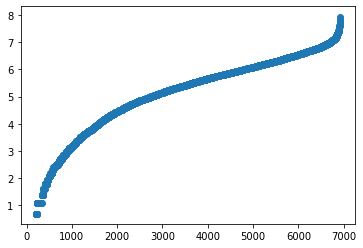

In [200]:
plt.scatter(x = np.arange(0, len(df['판매량'])), y = np.sort(np.log(df['판매량'].values)))